# Linear + Non-linear Regression

## Imports

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
sns.set_style('darkgrid')
import sklearn

In [4]:
df = pd.read_csv('../webscraping/moonboard_data.csv', index_col=0)
df = df.dropna()
df = df.query("angle == 40")
df.head()

,holds,grades,year,angle
0,"[('A18', 'end'), ('C10', 'hold'), ('D15', 'hol...",7B,2016,40
1,"[('E18', 'end'), ('F13', 'hold'), ('G6', 'star...",7B,2016,40
2,"[('E18', 'end'), ('F14', 'hold'), ('F9', 'hold...",7B,2016,40
3,"[('B3', 'start'), ('E10', 'hold'), ('F7', 'hol...",7B,2016,40
4,"[('D10', 'hold'), ('H18', 'end'), ('H14', 'hol...",7B,2016,40


<Axes: xlabel='grades', ylabel='Count'>

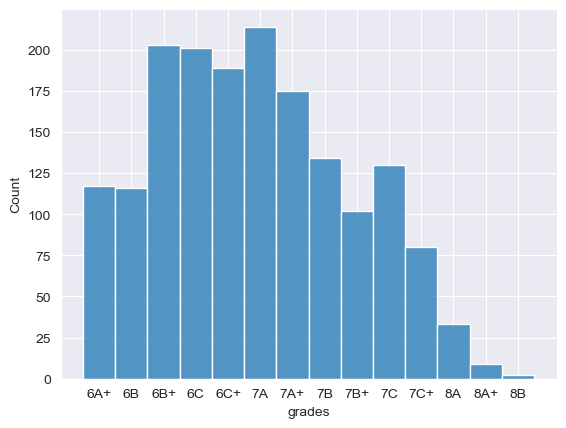

In [5]:
sns.histplot(data=df.sort_values('grades'), x='grades')

## Encoding holds as dictionary
Here we create a custom transformer which:
- drops null values from the `DataFrame`
- parses the string of holds into a list of holds
- encodes holds as a dictionary we can pass to `DictVectorizer`

In [6]:
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin 
from typing import List

class DictEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X: pd.DataFrame, y=None):
        return self
    
    def parseList(self, holdlist: List[str]):
        """ Parses a list of holds into a dicionary of the form {hold : 1} """
        return {hold : 1 for hold, color in holdlist}
    
    def transform(self, X: pd.DataFrame):
        """
        Encodes a list of holds into a dictionary of key, value pairs where
        each key is a hold of the form [column index A-K][row index 1-18]
        and each value is 1
        """
        X = X.dropna() # first drop missing values (problem no longer exists)
        X['holds'] = X['holds'].apply(lambda holdlist: self.parseList(eval(holdlist))) # parse strings to list of holds
        return X['holds']

In [7]:
from numpy import ndarray
from sklearn.base import BaseEstimator 
from sklearn.base import TransformerMixin 

class LabelEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X: pd.DataFrame, y=None):
        return self
    
    def grade_to_number(self, grade: str) -> int:
        """ Maps a route's grade to an integer """
        grade_dict = {
            '5+' : 0,
            '6A' : 1,
            '6A+' : 2,
            '6B' : 3,
            '6B+' : 4,
            '6C' : 5,
            '6C+' : 6,
            '7A' : 7,
            '7A+' : 8,
            '7B' : 9,
            '7B+' : 10,
            '7C' : 11,
            '7C+' : 12,
            '8A' : 13,
            '8A+' : 14,
            '8B' : 15,
            '8B+' : 16,
            '8C' : 17,
            '8C+' : 18
        }
        if grade not in grade_dict:
            raise Exception(f"Invalid Grade! {grade}")
        else:
            return grade_dict[grade]
    
    def transform(self, X: pd.DataFrame):
        """ Maps the `grades` column of a `DataFrame` to its numeric value (to be scaled) """
        X = X.dropna()
        X['grades_numeric'] = X['grades'].apply(self.grade_to_number) # parse grades to numeric value
        return X[['grades_numeric']]

## Vectorize features using `DictVectorizer`

## Build `Pipeline` to vectorize holds as feature matrix

We'll also try `Ridge` regression on the features to figure out how good the model is

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline 
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import Ridge

label_pipeline = Pipeline([
    ('encoder', LabelEncoder()),
    ('scaler', StandardScaler())
])

linear_model = Pipeline([
    ('encoder', DictEncoder()),
    ('vectorizer', DictVectorizer()),
    ('model', Ridge(alpha=4))
])

NameError: name 'DictVectorizer' is not defined

In [205]:
from sklearn.metrics import mean_squared_error

y = label_pipeline.fit_transform(df)
linear_model.fit(df, y)
preds = linear_model.predict(df)
mean_squared_error(y, preds)

0.4455106817962861

## Grid Search: Tuning `linear_model` hyperparameter `alpha`

In [211]:
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split 

df_40 = df.query("angle == 40")
df_40 = df_40.sample(frac=1)

param_grid = {'model__alpha' : np.arange(3.8,4.4,.02)}

search = GridSearchCV(linear_model, param_grid, cv=5)
search.fit(df_40, label_pipeline.fit_transform(df_40))
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.498):
{'model__alpha': 4.4}


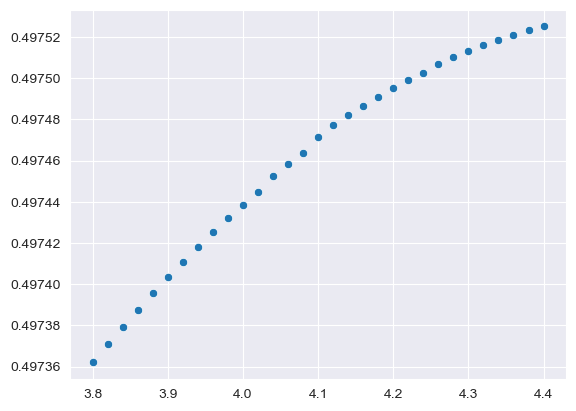

In [214]:
def plot_cv_results(gridsearch):
    params = [x['model__alpha'] for x in gridsearch.cv_results_['params']]
    sns.scatterplot(x=params, y=gridsearch.cv_results_['mean_test_score'])

plot_cv_results(search)


In [241]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

linear_model = Pipeline([
    ('encoder', DictEncoder()),
    ('vectorizer', DictVectorizer()),
    ('model', Ridge(alpha=4))
])

df_40 = df.query("angle == 40") # only use angle 40 since we mostly have those
X = df_40.sample(frac=1) # shuffle the data
y = label_pipeline.fit_transform(X) # map 

X_train, X_test, y_train, y_test = train_test_split(X, y)

linear_model.fit(X_train, y_train)
linear_model.score(X_test, y_test)

0.49405350324876174